# Timeflux Oddball device benchmark using MOABB formalism


In [1]:
import os
import logging

import matplotlib.pyplot as plt
import mne
from mne.epochs import Epochs
from mne.preprocessing import Xdawn
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import (P300)
import pandas as pd
import seaborn as sns
from sklearn.base import clone
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from utils.moabb import TxOddall
from utils.pipelines import pipelines
logger = logging.getLogger()


# Load and prepare the data 
## Define P300 paradigm

A paradigm defines how the raw data will be converted to trials ready
to be processed by a decoding algorithm and what metric should be used to compare algorith
with one another

In [2]:
paradigm = P300()

print(paradigm.__doc__)


P300 for Target/NonTarget classification

    Metric is 'roc_auc'

    


## Choose a Timeflux oddball datasets

In [3]:
dataset = TxOddall(datapath="/Users/raph/TIMEFLUX_DATA/ODDBALL/raw_datasets")
data = dataset.get_data()
devices = dataset.subject_list
N = len(devices)

2020-04-10 22:46:40 anonymous.local numexpr.utils[10995] INFO Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-04-10 22:46:40 anonymous.local numexpr.utils[10995] INFO NumExpr defaulting to 8 threads.
/Users/raph/miniconda3/envs/eeg_oddball_benchmark-env/lib/python3.7/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# Compare the datasets 
## Plot PSD of raw signals across datasets

/Users/raph/miniconda3/envs/eeg_oddball_benchmark-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


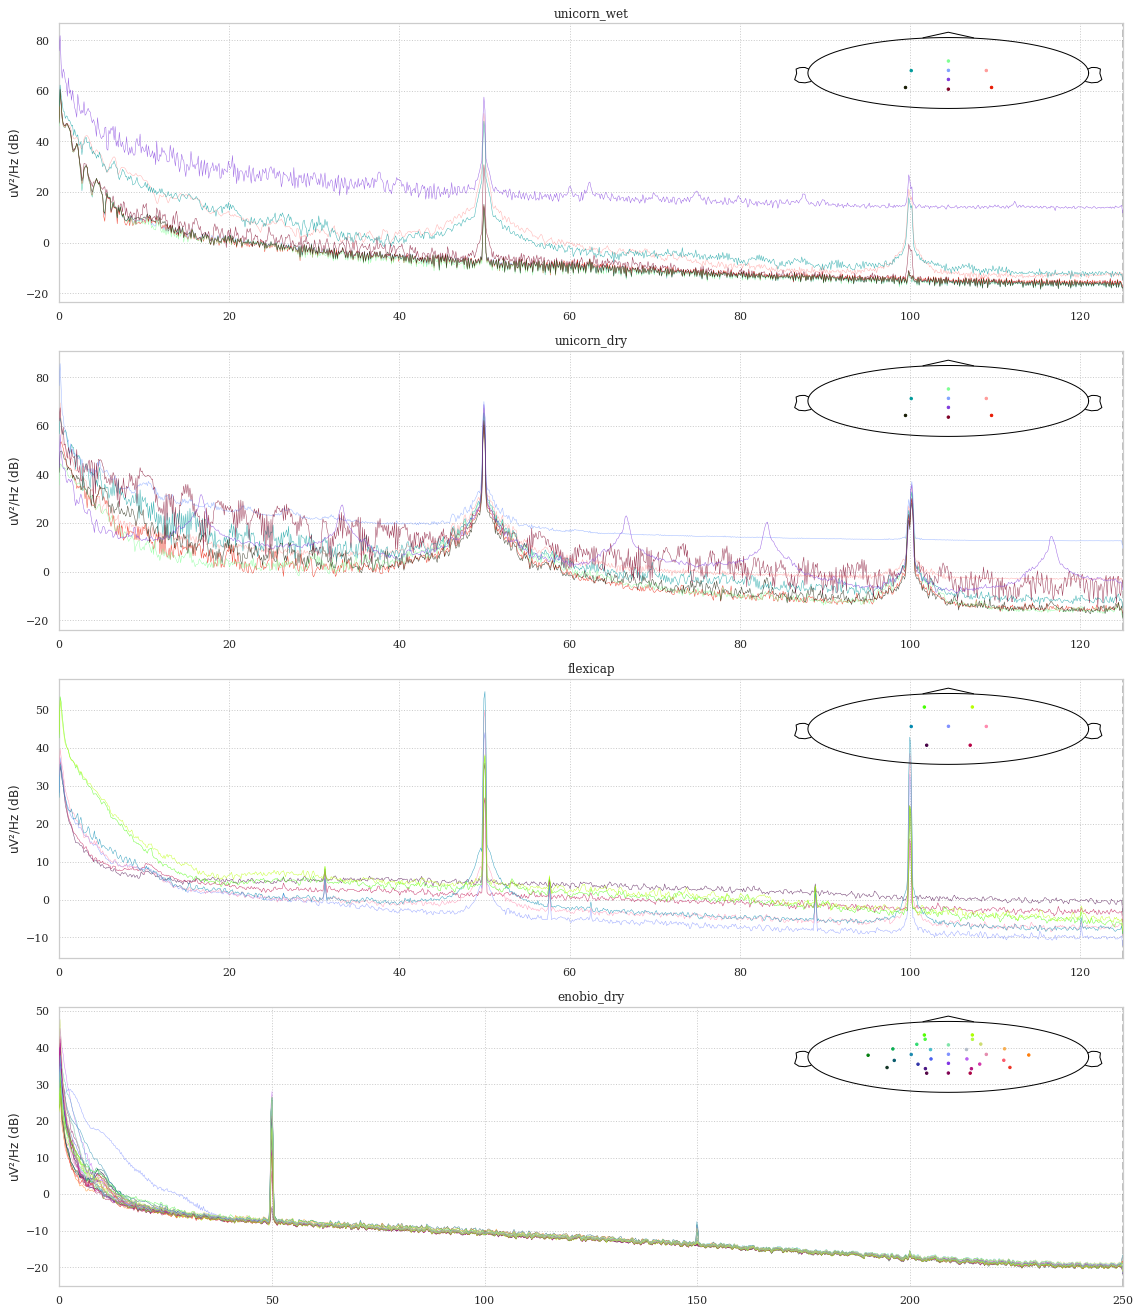

In [4]:
f, ax = plt.subplots(N, 1, figsize=( 4 ,5*N))
for k_plot, device in enumerate(devices):
    raw = list(list(data[device].values())[0].values())[0]
    raw.plot_psd(ax=ax[k_plot], show=False)
    ax[k_plot].set_title(device)
plt.tight_layout(rect=[0, 0.03, 4, 0.95])
plt.show()

## Plot XDAWN first components of standard/deviant dissociation across datasets 

In [5]:
raw.filter(1, 20, fir_design='firwin')

events = mne.find_events(raw)
labels = events[:, -1]
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')
epochs = Epochs(raw, events, event_id=dataset.event_id, tmin=-0.1, tmax=.6, proj=False,
                baseline=None, preload=True, picks=picks,
                verbose=False)
n_filter = 1
xdawn = Xdawn(n_components=n_filter)


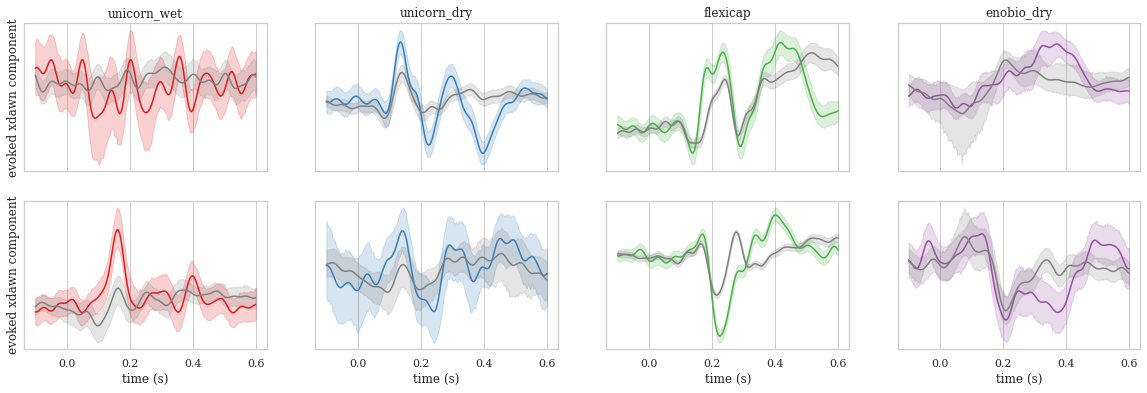

In [6]:
f, ax = plt.subplots(2, N,
                     figsize=(5*N, 3*2),
                     sharex=True)
palette = sns.color_palette("Set1", n_colors=8)
for k_device, device in enumerate(devices):
    raw = list(list(data[device].values())[0].values())[0] # first component
    raw.filter(1, 20, fir_design='firwin')

    event_id = dataset.event_id
    events = mne.find_events(raw)
    labels = events[:, -1]
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                           exclude='bads')
    epochs = Epochs(raw, events, event_id=dataset.event_id, tmin=-0.1, tmax=.6, proj=False,
                    baseline=None, preload=True, picks=picks,
                    verbose=False)
    transformed_epochs = xdawn.fit_transform(epochs, labels)
    ax[0, k_device].set_title(device)
    # plot the stuff
    for k_filter in range(2):
        sub = ax[k_filter, k_device]
        xdawn_fkilter = pd.DataFrame(transformed_epochs[:, k_filter, :], columns=epochs.times)
        xdawn_fkilter['label'] = labels
        xdawn_fkilter = xdawn_fkilter.melt('label')
        sns.lineplot(data=xdawn_fkilter[xdawn_fkilter.label==event_id['Target']],
                     x='variable', y='value', ax=sub, color=palette[k_device])
        sns.lineplot(data=xdawn_fkilter[xdawn_fkilter.label==event_id['NonTarget']],
                     x='variable', y='value', ax=sub, color='gray')
        sub.set_yticks([])
        sub.set_ylabel('')
        ax[k_filter, 0].set_ylabel('evoked xdawn component')
        sub.set_xlabel('time (s)')


## Run classification pipelienes and plot AUC ROC across datasets

In [7]:
X, y, _ = paradigm.process_raw(raw, dataset)
ALL_SCORES = []
ntest = 100
for k_plot, device in enumerate(devices):
    print(device)
    for acquisition, data_per_acquisition in data[device].items():
        pipeline = clone(pipelines['ERPCov + TS'])
        for run, data_per_run in data_per_acquisition.items():
            ntrains = [10, 50, 100, 150, 200, 300, 400, 500]
            raw = data_per_run
            X, y, _ = paradigm.process_raw(raw, dataset)
            max_ntrains = len(y) - ntest
            if max(ntrains) > max_ntrains:
                logger.warning(f'Not enough data to train on more than {max_ntrains} trials.')
                ntrains = [ntrain for ntrain in ntrains if ntrain < max_ntrains]

            le = LabelEncoder()
            y = le.fit_transform(y)
            scores = []
            for ntrain in ntrains:
                pipeline.fit(X[:ntrain,:,:], y[:ntrain])
                targets = y[-ntest:]
                predictions = pipeline.predict(X[-ntest:,:,:])
                auc_roc = roc_auc_score(targets, predictions)
                scores.append(auc_roc)
            scores_df = pd.DataFrame(scores, columns=['score'])
            scores_df['device'] = device
            scores_df.loc[:, 'num_train'] = ntrains
            scores_df.loc[:, 'acquisition'] = acquisition
            ALL_SCORES.append(scores_df)
ALL_SCORES_DF = pd.concat(ALL_SCORES)


unicorn_wet
unicorn_dry
flexicap
enobio_dry


Text(0.5, 0.98, 'ROC AUC against calibration size')

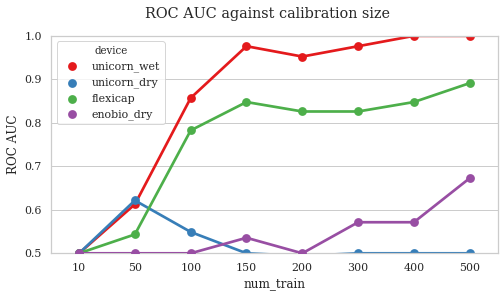

In [8]:
f, ax = plt.subplots(facecolor='white', figsize=[8, 4])
sns.pointplot(data=ALL_SCORES_DF,
              x='num_train',
              y='score',
              hue='device',
              palette="Set1",
              style="device",
              ax=ax)
ax.set_ylabel('ROC AUC')
ax.set_ylim(0.5, 1)
plt.suptitle('ROC AUC against calibration size')
